# Uplift_modelling

### 1. Введение

По типу реакции на коммуникации пользователи делятся на 4 типа:

* **Спящая собака** - человек, который будет реагировать негативно, если с ним прокоммуницировать. Яркий пример: клиенты, которые забыли про платную подписку. Получив напоминание об этом, они обязательно ее отключат. Но если их не трогать, то клиенты по-прежнему будут приносить деньги.
* **Потерянный** - человек, который не совершит целевое действие независимо от коммуникаций. Взаимодействие с такими клиентами не приносит дополнительного дохода, но создает дополнительные затраты.
* **Уверенный** - человек, который будет реагировать положительно, несмотря ни на что - самый лояльный вид клиентов. По аналогии с предыдущим пунктом, такие клиенты также расходуют ресурсы. Однако в данном случае расходы гораздо больше, так как уверенные еще и пользуются маркетинговым предложением (скидками, купонами и другое).
* **Убеждаемый** - это человек, который положительно реагирует на предложение, но при его отсутствии не выполнил бы целевого действия. Это те люди, которых мы хотели бы определить нашей моделью, чтобы с ними прокоммуницировать.


Вероятность оттока ($y$) при целевом воздействии ($w$): $$P_{treatment} = P(y=1|w=1)$$

Вероятность оттока ($y$) при отсутствии целевого воздействия ($w$):$$P_{control} = P(y=1|w=0)$$

$$uplift = P_{control} - P_{treatment}$$

Модель uplifta - это то, что реально нужно бизнесу

Порядок процесса Uplift-моделирования следующий:

1. Данные делим на 2 части (treatment и control)
2. Проводим A/B test и собираем таргет, как отреагировали люди из этих групп
3. По собранной выборке строим uplift модель


### 2. Подходы в решению задачи

* С одной моделью (**SoloModel**)
* С двумя моделями (**TwoModels**)
* Трансформация таргета (**ClassTransformation**)
* Решеющие деревья с uplift-критерием разделения

### 2.1 Применение одной модели с бинарной фичей Treatment ($w$)

1. Добавляем фичу treatment/control
2. Делаем предсказание на тестовой выборке сначала с 1, а потом с 0
3. Вычитаем одно предсказание из другого и получаем uplift

<img align="center" src="../img/one_model_with_treatment_feature.png"/>

**Подготовка данных**

In [2]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split

In [14]:
df_clients = pd.read_csv('../data_uplift/clients.csv', index_col='client_id')
df_train = pd.read_csv('../data_uplift/uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('../data_uplift/uplift_test.csv', index_col='client_id')

In [15]:
# Извлечение признаков
df_features = df_clients.copy()
df_features['first_issue_time'] = pd.to_datetime(df_features['first_issue_date']).astype(int) / 10 ** 9
df_features['first_redeem_time'] = pd.to_datetime(df_features['first_redeem_date']).astype(int) / 10 ** 9
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

Пример тренировочной выборки

In [24]:
pd.concat([df_features, df_train], axis=1,sort=False).dropna(subset=['target']).head()

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay,treatment_flg,target
000012768d,45,U,1.501948e+09,1.515094e+09,13146559.0,0.0,1.0
000036f903,72,F,1.491832e+09,1.492951e+09,1118613.0,1.0,1.0
00010925a5,83,U,1.532449e+09,1.536942e+09,4492280.0,1.0,1.0
0001f552b0,33,F,1.498850e+09,1.535461e+09,36610747.0,1.0,1.0
00020e7b18,73,U,1.511783e+09,1.515607e+09,3823700.0,1.0,1.0


In [12]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

cat_features = ['gender']

**Построение модели**

In [25]:
#!pip install scikit-uplift

# Воспользуемся готовой библиотекой
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Инстркция на документацию: https://scikit-uplift.readthedocs.io/en/latest/

In [21]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds, plot_uplift_qini_curves
from sklift.models import SoloModel

from catboost import CatBoostClassifier

In [15]:
sm = SoloModel(CatBoostClassifier(thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, k=0.3)

In [33]:
sm_score

0.03448807617551386

In [16]:
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

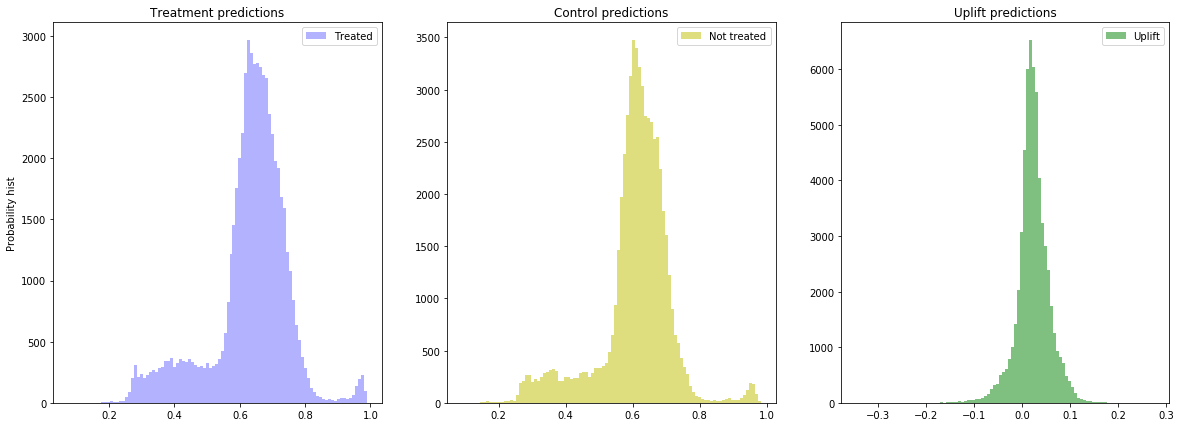

In [17]:
# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

### 2.2 Трансформация классов

Создаем новую целевую переменную: $$z_i=y_i∗w_i+(1−y_i)∗(1−w_i)$$

\begin{equation*}
 \begin{cases}
   1, &\text{если $w_i$=1 и $y_i$=1} 
   \\
   1, &\text{если $w_i$=0 и $y_i$=0}
   \\
   0, &\text{в остальный случаях}
 \end{cases}
\end{equation*}

Uplift считается по формуле: $$uplift = 2 * p(z = 1|x) - 1$$ 

Таким образом, увеличив вдвое прогноз нового таргета и вычтя из него единицу мы получим значение самого uplift'a. 
Данный подход следует использовать только в случаях, когда количество клиентов, с которыми мы прокоммуницировлаи, равно количеству клиентов, с которыми коммуникации не было

In [29]:
from sklift.models import ClassTransformation

ct = ClassTransformation(CatBoostClassifier(thread_count=2, silent=True, random_state=43))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


/home/mikhail/venv/mlprojects/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  after removing the cwd from sys.path.


In [30]:
uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, k=0.3)

In [31]:
ct_score

0.05427971137093768

### 2.3 Решающее дерево

Суть подхода заключается в построении решающего дерева, максимизирующего разницу в аплифте между нодой и листьями

### 3. Метрики

В задачах моделирования uplift-а клиенты из тестовой выборки ранжируются по убыванию эффективности коммуникации. Из ранжированного списка выбирается, например, топ 30% (наиболее перспективные) и по выбранным 30% оценивается среднее значение Uplift. Простым языком, вычисляется средний прирост отклика при воздействии на клиента.

**3.1 Area Under Uplift_curve / Gain_chart**

<img align="center" src="../img/uplift_curve.png"/>

По оси $X$ откладывается кумулятивная доля объектов (перцентили или со сколькими людьми готовы взаимодействовать)

По оси $Y$ откладываются кумулятивная доля uplift

<img align="center" src="../img/cumulative_gain_chart.png"/>

**Ссылки**

* https://github.com/maks-sh/scikit-uplift . Python module for classic approaches for uplift modelling built on top of scikit-learn.

* https://nbviewer.jupyter.org/github/maks-sh/scikit-uplift/blob/master/notebooks/RetailHero.ipynb
* https://www.youtube.com/watch?v=yFQAIJBYXI0&feature=youtu.be
* https://www.youtube.com/watch?v=jCUcYiBK03I

* http://mlwiki.org/index.php/Cumulative_Gain_Chart

* https://habr.com/ru/company/ods/blog/350440/